Usando mnist como dataset
Encontrados 6 pares de modelos.

🧩 Cargando modelos para configuración: 128_lat_2_mnist.keras

✅ Modelo '128_lat_2_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 128_lat_64_mnist.keras
✅ Modelo '128_lat_64_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 128_lat_64_mnist_beta_10.keras
✅ Modelo '128_lat_64_mnist_beta_10.keras' procesado.

🧩 Cargando modelos para configuración: 256_lat_128_mnist.keras
✅ Modelo '256_lat_128_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 256_lat_64_mnist.keras
✅ Modelo '256_lat_64_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 512_lat_256_mnist.keras
✅ Modelo '512_lat_256_mnist.keras' procesado.


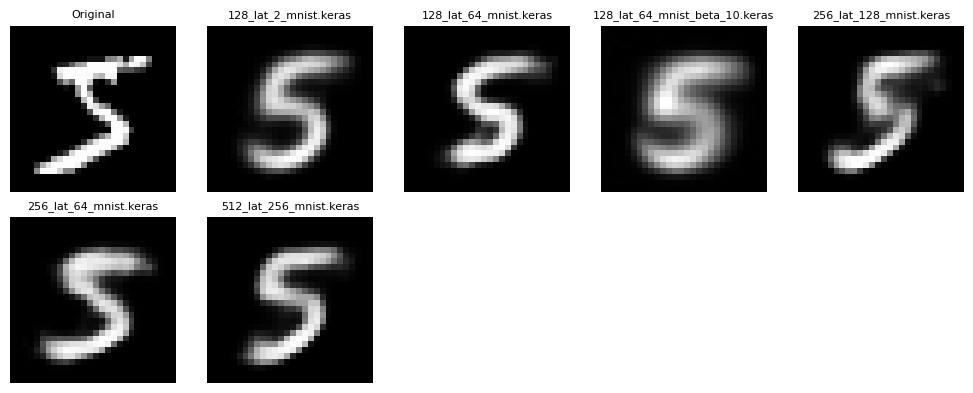

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Agregar carpeta raíz al path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# Importar módulos propios
from Datos.Data_acq import get_mnist_data
from models.cVAE import CVAE
from custom_layers.Sampling import Sampling

# Cargar datos
x_train, x_test, x_val, y_train, y_test, y_val, x_train_1, y_train_1 = get_mnist_data()

# Rutas a los modelos
ENCODER_DIR = "../../modelos_entrenados/encoders/"
DECODER_DIR = "../../modelos_entrenados/decoders/"
ORIGINAL_DIM = 28 * 28

# Obtener listas de archivos
encoder_files = sorted(os.listdir(ENCODER_DIR))
decoder_files = sorted(os.listdir(DECODER_DIR))


# Función para extraer clave
def get_key(filename):
    return "_".join(filename.split("_")[2:])  # ej: 'lat_2_mnist.keras'


# Crear diccionarios clave → path
encoders = {
    get_key(f): os.path.join(ENCODER_DIR, f)
    for f in encoder_files
    if f.endswith(".keras")
}
decoders = {
    get_key(f): os.path.join(DECODER_DIR, f)
    for f in decoder_files
    if f.endswith(".keras")
}

# Claves comunes entre encoder y decoder
common_keys = sorted(set(encoders.keys()) & set(decoders.keys()))
print(f"Encontrados {len(common_keys)} pares de modelos.")

# Imagen original
x_input = x_train[:1]  # Imagen original
cond_input = y_train[:1]  # Condición
original_image = x_input[0].reshape(28, 28)

# Guardar imágenes reconstruidas + nombres
reconstructed_images = [original_image]
model_names = ["Original"]

# Iterar sobre modelos
for key in common_keys:
    print(f"\n🧩 Cargando modelos para configuración: {key}")

    encoder_path = encoders[key]
    decoder_path = decoders[key]

    encoder = load_model(encoder_path, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path)

    cvae = CVAE(encoder, decoder, original_dim=ORIGINAL_DIM)
    cvae.compile(optimizer="adam")

    # Codificar y decodificar
    z_mean, z_log_var, z = cvae.encoder.predict([x_input, cond_input], verbose=0)
    reconstructed = cvae.decoder.predict([z, cond_input], verbose=0)

    # Guardar imagen
    reconstructed_images.append(reconstructed[0].reshape(28, 28))
    model_names.append(key)

    print(f"✅ Modelo '{key}' procesado.")

# Mostrar todas las imágenes en una sola figura
num_images = len(reconstructed_images)
cols = min(5, num_images)
rows = (num_images + cols - 1) // cols

plt.figure(figsize=(cols * 2, rows * 2))

for i, (img, name) in enumerate(zip(reconstructed_images, model_names)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(name, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from keras.models import load_model

from custom_layers.Sampling import Sampling
from custom_layers.ReshapeLayer import ReshapeLayer

from Datos.Data_acq import get_mnist_data
from models.cVAE import CVAE
from inferencias.inferencia import separar_digitos


x_train, x_test, x_val, y_train, y_test, y_val, x_train_1, y_train_1 = get_mnist_data(
    dataset="fashion"
)


encoder = load_model(
    "../../modelos_entrenados/encoders_fashion/en_int_256_lat_128_fashion.keras",
    custom_objects={"Sampling": Sampling},
)

decoder = load_model(
    "../../modelos_entrenados/decoders_fashion/de_int_256_lat_128_fashion.keras"
)

cvae = CVAE(encoder=encoder, decoder=decoder, original_dim=28 * 28, beta=1)

predictor = load_model(
    "../../modelos_entrenados/predictores/CCE_Conv2D_fashion.keras",
    {"ReshapeLayer": ReshapeLayer},
)


def objective(trial):
    bias = trial.suggest_float("bias", 0.1, 5.0)
    slope = trial.suggest_float("slope", 10.0, 60.0)

    # print(f"Probando bias={bias}, slope={slope}")

    try:
        bpsnr, bpsnr_d, _ = separar_digitos(
            x_train[:1000],
            x_train_1[:1000],
            y_train[:1000],
            y_train_1[:1000],
            cvae,
            predictor,
            bias=bias,
            slope=slope,
            Iterations=3,
        )
        # print(f"Resultado OK: bpsnr = mean: {bpsnr[0]} std: {bpsnr[1]}\n")
        # print(f"Resultado OK: bpsnr = mean: {bpsnr_d[0]} std: {bpsnr_d[1]}\n")

        return bpsnr[0]

    except Exception as e:
        print(f"Error con bias={bias}, slope={slope}: {e}")
        # Podés penalizarlo con un valor muy alto
        return float("inf")

Usando fashion como dataset


In [ ]:
import optuna

# Creamos un estudio de minimización
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)  # Probamos 30 combinaciones

# Mostramos los mejores resultados
print("\n📊 Mejores hiperparámetros encontrados:")
print(study.best_params)
print("🔽 Mejor bpsnr_mean:", study.best_value)

[I 2025-08-06 18:00:36,924] A new study created in memory with name: no-name-cbbef4a8-8075-4a56-b48f-ce01b207d9d6
[I 2025-08-06 18:00:42,527] Trial 0 finished with value: 7.662317276000977 and parameters: {'bias': 2.7994289937972465, 'slope': 51.489430840015984}. Best is trial 0 with value: 7.662317276000977.
[I 2025-08-06 18:00:48,755] Trial 1 finished with value: 7.662317276000977 and parameters: {'bias': 1.8083482203268604, 'slope': 25.354697674433517}. Best is trial 0 with value: 7.662317276000977.
[I 2025-08-06 18:00:53,808] Trial 2 finished with value: 7.662317276000977 and parameters: {'bias': 3.498290122256593, 'slope': 20.03364486755648}. Best is trial 0 with value: 7.662317276000977.
[I 2025-08-06 18:00:59,057] Trial 3 finished with value: 9.23784351348877 and parameters: {'bias': 0.9422019780431966, 'slope': 25.027540134474286}. Best is trial 3 with value: 9.23784351348877.
[I 2025-08-06 18:01:04,308] Trial 4 finished with value: 7.662317276000977 and parameters: {'bias': 3.


📊 Mejores hiperparámetros encontrados:
{'bias': 0.25629172824472013, 'slope': 10.006709538296949}
🔽 Mejor bpsnr_mean: 15.741589546203613


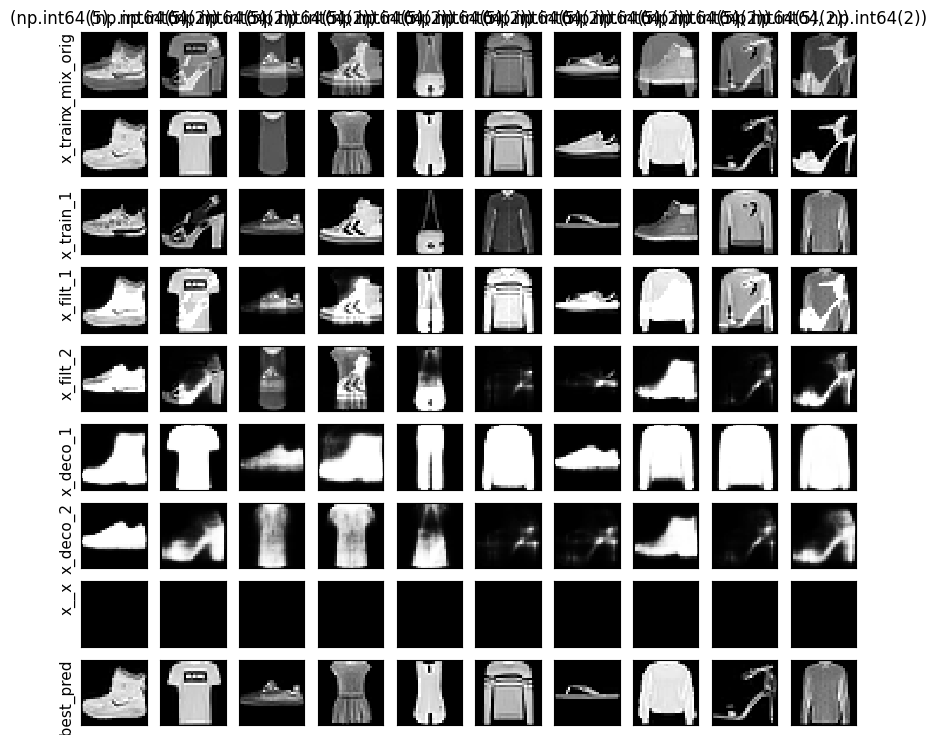

((<tf.Tensor: shape=(), dtype=float32, numpy=15.81317138671875>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.9018746614456177>),
 array([[2.32881902e-07, 2.78806471e-08, 8.54990617e-07, 3.36308204e-07,
         2.94186029e-05, 6.90085639e-04, 4.18741583e-05, 3.48071707e-03,
         1.85662138e-04, 9.95570779e-01],
        [9.94822621e-01, 1.29063994e-06, 3.36501282e-03, 5.23278897e-04,
         1.03444575e-06, 7.28054950e-10, 1.24615605e-03, 1.34607106e-07,
         4.04565908e-05, 2.65666227e-08],
        [4.08665597e-04, 4.65923571e-04, 2.16661952e-02, 1.36909140e-02,
         9.35468473e-04, 3.45110497e-03, 2.02168468e-02, 9.38308060e-01,
         2.21090610e-04, 6.35705830e-04],
        [1.06619336e-04, 4.64511832e-05, 9.55010299e-04, 1.81248633e-03,
         1.90068342e-04, 1.38402474e-03, 4.11340684e-01, 7.90846944e-02,
         7.93869514e-03, 4.97141361e-01],
        [6.95780143e-02, 6.92658365e-01, 4.23546997e-04, 2.17233106e-01,
         2.13785260e-03, 1.19395838e-06, 1.

In [ ]:
separar_digitos(
    x_train[:10],
    x_train_1[:10],
    y_train[:10],
    y_train_1[:10],
    cvae,
    predictor,
    Iterations=3,
    show_graph=True,
)

Mejores hiperparámetros encontrados:
{'bias': 0.25629172824472013, 'slope': 10.006709538296949}


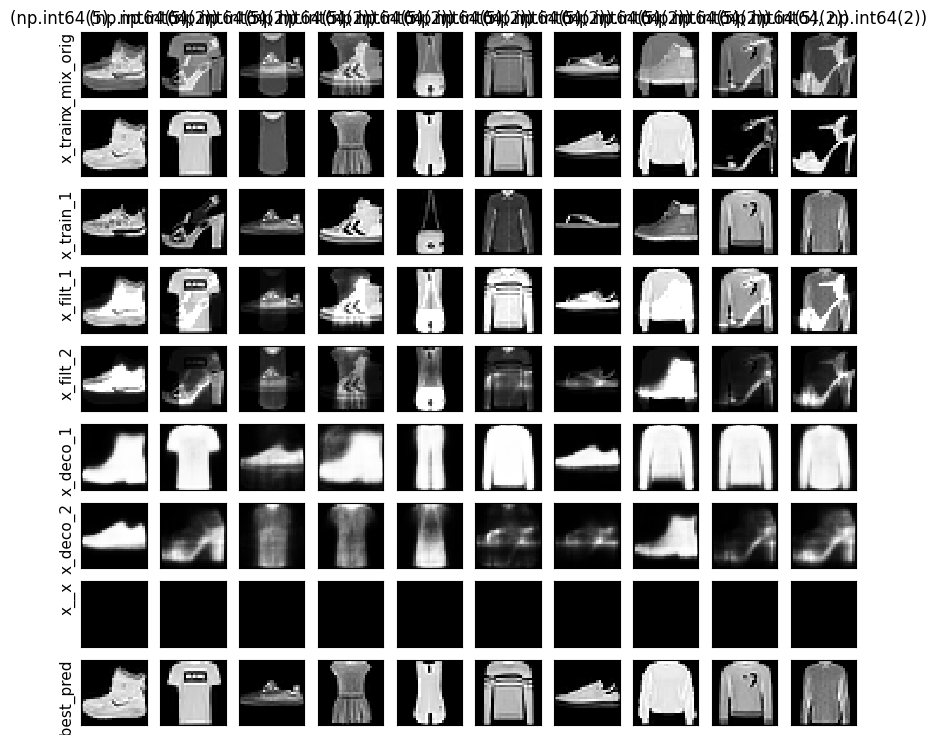

((<tf.Tensor: shape=(), dtype=float32, numpy=16.606739044189453>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.6460994482040405>),
 array([[4.32278057e-07, 1.20840085e-07, 6.23381948e-06, 2.13221188e-06,
         8.52603116e-05, 8.41104367e-04, 9.20833700e-05, 1.33949472e-02,
         7.01009820e-04, 9.84876692e-01],
        [9.50719953e-01, 4.36157779e-06, 4.05152552e-02, 1.41453743e-03,
         3.13304299e-05, 6.72899692e-09, 6.50874013e-03, 1.31525494e-05,
         7.82911316e-04, 9.65478284e-06],
        [3.89839686e-03, 1.48895907e-03, 4.29640450e-02, 1.38712540e-01,
         4.65600472e-03, 1.78861679e-04, 8.04089308e-02, 7.26203859e-01,
         3.86987260e-04, 1.10140583e-03],
        [8.38814070e-04, 3.28945171e-04, 2.83383811e-03, 7.14239152e-03,
         5.30949546e-05, 3.44757224e-04, 4.08689618e-01, 1.95219487e-01,
         1.24301587e-03, 3.83306086e-01],
        [1.90637216e-01, 2.93594629e-01, 1.74798735e-03, 4.06703085e-01,
         1.95623562e-03, 5.31015485e-06, 1

In [ ]:
num_images = 10
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
# study.best_value


separar_digitos(
    x_train[:10],
    x_train_1[:10],
    y_train[:10],
    y_train_1[:10],
    cvae,
    predictor,
    bias=study.best_params["bias"],
    slope=study.best_params["slope"],
    Iterations=3,
    show_graph=True,
)

### Prueba para mnist

Usando mnist como dataset


[I 2025-08-06 18:08:03,775] A new study created in memory with name: no-name-7ce3a888-ecb9-4666-9ac6-7c6e071817fc
[I 2025-08-06 18:08:10,084] Trial 0 finished with value: 11.617466926574707 and parameters: {'bias': 0.8940463102362407, 'slope': 45.97525738056944}. Best is trial 0 with value: 11.617466926574707.
[I 2025-08-06 18:08:15,060] Trial 1 finished with value: 9.869382858276367 and parameters: {'bias': 4.86409997426624, 'slope': 18.357250336145572}. Best is trial 0 with value: 11.617466926574707.
[I 2025-08-06 18:08:20,067] Trial 2 finished with value: 9.869382858276367 and parameters: {'bias': 2.5183289771677657, 'slope': 21.252319443872068}. Best is trial 0 with value: 11.617466926574707.
[I 2025-08-06 18:08:25,877] Trial 3 finished with value: 9.869382858276367 and parameters: {'bias': 1.8409453482347922, 'slope': 47.46751253386725}. Best is trial 0 with value: 11.617466926574707.
[I 2025-08-06 18:08:31,370] Trial 4 finished with value: 9.869382858276367 and parameters: {'bias

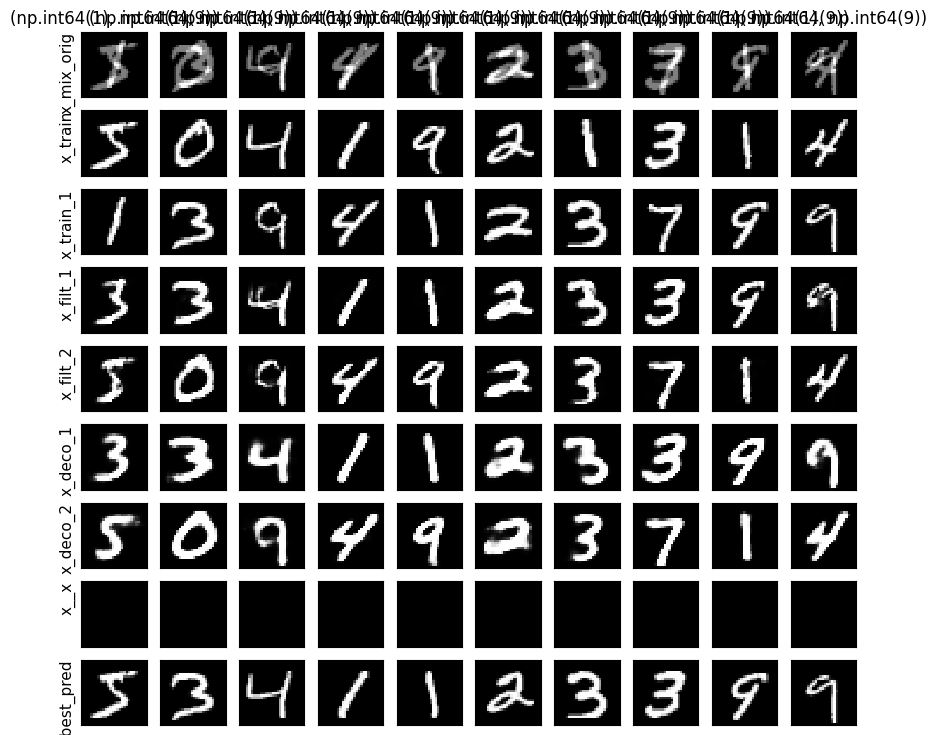


📊 Mejores hiperparámetros encontrados:
{'bias': 0.18465508142867743, 'slope': 45.94998766829924}
🔽 Mejor bpsnr_mean: 16.85556411743164
Mejores hiperparámetros encontrados


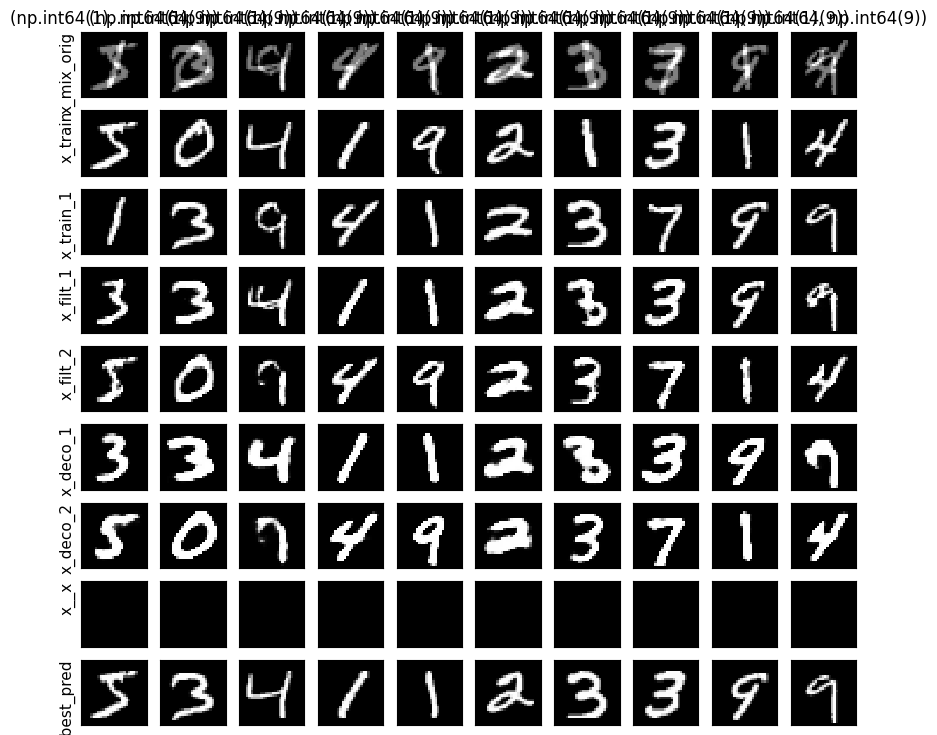

((<tf.Tensor: shape=(), dtype=float32, numpy=16.990381240844727>,
  <tf.Tensor: shape=(), dtype=float32, numpy=3.295832872390747>),
 array([[4.0567166e-08, 9.3413641e-05, 6.3935848e-09, 9.9976230e-01,
         7.8848439e-05, 4.2134230e-05, 2.9386549e-06, 4.6265050e-06,
         8.6846885e-06, 6.9409293e-06],
        [2.3204225e-11, 2.3518276e-10, 7.4533873e-06, 9.9999231e-01,
         3.7403172e-14, 5.1429452e-09, 2.7714613e-15, 2.5726253e-08,
         6.6613616e-08, 1.0766359e-07],
        [1.4103388e-11, 1.4212460e-05, 2.8669282e-08, 7.2711941e-08,
         9.9256212e-01, 5.5922356e-09, 2.5552824e-09, 3.3085573e-05,
         6.1087601e-05, 7.3294467e-03],
        [4.5799193e-06, 9.7953826e-01, 7.3015998e-04, 2.6032794e-03,
         3.7784989e-03, 1.4473591e-05, 2.8914886e-07, 7.7984035e-03,
         5.0519872e-03, 4.8009714e-04],
        [4.7061670e-07, 9.8581505e-01, 5.2870790e-05, 1.4342209e-04,
         9.4651867e-04, 1.3768632e-05, 2.4375348e-07, 1.7069813e-04,
         1.2629585

In [ ]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from keras.models import load_model

from custom_layers.Sampling import Sampling
from custom_layers.ReshapeLayer import ReshapeLayer

from Datos.Data_acq import get_mnist_data
from models.cVAE import CVAE
from inferencias.inferencia import separar_digitos


x_train, x_test, x_val, y_train, y_test, y_val, x_train_1, y_train_1 = get_mnist_data()


encoder = load_model(
    "../../modelos_entrenados/encoders/en_int_256_lat_128_mnist.keras",
    custom_objects={"Sampling": Sampling},
)

decoder = load_model(
    "../../modelos_entrenados/decoders/de_int_256_lat_128_mnist.keras"
)

cvae = CVAE(encoder=encoder, decoder=decoder, original_dim=28 * 28, beta=1)

predictor = load_model(
    "../../modelos_entrenados/predictores/CCE_Conv2D.keras",
    {"ReshapeLayer": ReshapeLayer},
)


def objective(trial):
    bias = trial.suggest_float("bias", 0.1, 5.0)
    slope = trial.suggest_float("slope", 10.0, 60.0)

    # print(f"Probando bias={bias}, slope={slope}")

    try:
        bpsnr, bpsnr_d, _ = separar_digitos(
            x_train[:1000],
            x_train_1[:1000],
            y_train[:1000],
            y_train_1[:1000],
            cvae,
            predictor,
            bias=bias,
            slope=slope,
            Iterations=3,
        )
        # print(f"Resultado OK: bpsnr = mean: {bpsnr[0]} std: {bpsnr[1]}\n")
        # print(f"Resultado OK: bpsnr = mean: {bpsnr_d[0]} std: {bpsnr_d[1]}\n")

        return bpsnr[0]

    except Exception as e:
        print(f"Error con bias={bias}, slope={slope}: {e}")
        # Podés penalizarlo con un valor muy alto
        return float("inf")
    

import optuna

# Creamos un estudio de minimización
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)  # Probamos 30 combinaciones


separar_digitos(
    x_train[:10],
    x_train_1[:10],
    y_train[:10],
    y_train_1[:10],
    cvae,
    predictor,
    Iterations=3,
    show_graph=True,
)


# Mostramos los mejores resultados
print("\n📊 Mejores hiperparámetros encontrados:")
print(study.best_params)
print("🔽 Mejor bpsnr_mean:", study.best_value)



Mejores hiperparámetros encontrados


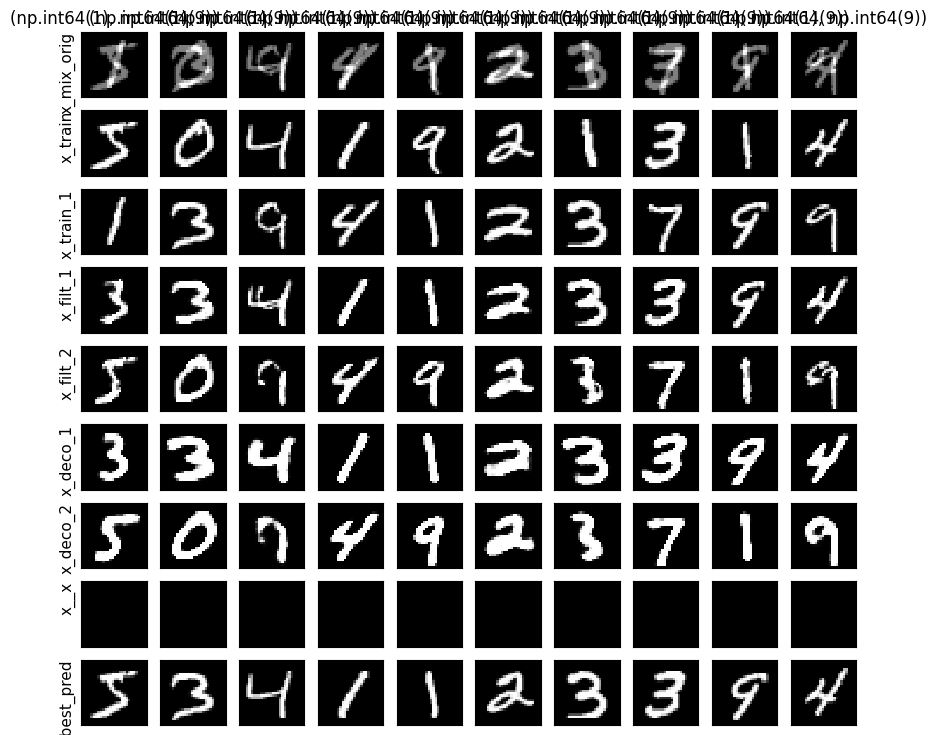

((<tf.Tensor: shape=(), dtype=float32, numpy=17.724319458007812>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.5010321140289307>),
 array([[4.65337462e-06, 2.23831623e-03, 3.14722712e-07, 9.94665980e-01,
         1.74287928e-03, 2.35037063e-04, 3.44204629e-04, 3.29861330e-04,
         3.75897071e-04, 6.28591515e-05],
        [2.05833850e-10, 2.46444393e-10, 5.87846580e-06, 9.99993742e-01,
         1.26973661e-14, 5.93899818e-09, 4.23230388e-15, 1.13871792e-08,
         2.71512278e-07, 4.56003946e-08],
        [1.01040435e-11, 1.26762361e-05, 1.61117537e-08, 7.59121619e-08,
         9.95538354e-01, 4.57237759e-09, 2.35256845e-08, 2.66357492e-05,
         9.79275137e-05, 4.32432210e-03],
        [1.54704594e-05, 9.61401582e-01, 1.47545128e-03, 4.46076412e-03,
         4.59409552e-03, 6.79993900e-06, 1.58395721e-06, 7.35540548e-03,
         1.99981593e-02, 6.90798508e-04],
        [2.26108099e-07, 9.94564712e-01, 1.24280214e-05, 4.14494207e-05,
         5.24349685e-04, 8.28735483e-06, 2

In [30]:
print("Mejores hiperparámetros encontrados")


separar_digitos(
    x_train[:10],
    x_train_1[:10],
    y_train[:10],
    y_train_1[:10],
    cvae,
    predictor,
    bias=study.best_params["bias"],
    slope=study.best_params["slope"],
    Iterations=10,
    show_graph=True,
)